# 0.0. Imports

In [52]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib
from  IPython.core.display import HTML
from IPython.display import Image
from scipy                 import stats as ss
from tabulate              import tabulate

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on= 'Store' )

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw

## 1.1 Rename

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
        'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
        'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Rows:{}'.format(df1.shape[0]))
print('Cols:{}'.format(df1.shape[1]))

Rows:1017209
Cols:18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance            
     #logica detalhada
     # df1['competition_distance']= df1['competition_distance'].apply(lambda df1: 200000.0 if math.isnan(df1['competition_distance'])else df1['competition_distance'])
        
df1['competition_distance']=  df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else (x))

#competition_open_since_month  
    #lógica detalhada
    #df1['competition_open_since_month'] = df1['competition_open_since_month'].apply(lambda df1: df1['date'] if math.isnan(df1['competition_open_since_month']) else df1['competition_open_since_month'])
    #Como precisa verificar a coluna date e a coluna competition_open_since_month é necessário colocar o DF1 no apply no df1 inteiro e colocar axis 1 para que ele varra todas as colunas
    #alternativa mais rápida: df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis =1)

#competition_open_since_year  
    #alternativa mais rápida df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

#promo2_since_week   
    #alternativa mais rápida df1.promo2_since_week.fillna(df1.date.dt.isocalendar().week, inplace=True)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

#promo2_since_year    
    #alternativa mais rápida df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
    #logica detalhada
    #df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda df1: 0 if df1['promo_interval'] == 0 else 1 if df1['month_map'] in df1['promo_interval'].split(',') else 0, axis=1)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6 Change Types

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [13]:
#criar df com colunas numéricas e colunas floats 
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime'])

### 1.7.1 Numerical Atributes

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T
                  
#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2,d1, d5, d6]).T.reset_index()
m.columns =['attributes','min','max','range','mean','median','std','skew','kurtosis']
m                  

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


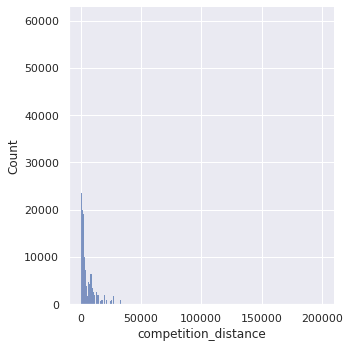

In [15]:
sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Atributes

In [16]:
#valores únicos nas variaveis categóricas
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

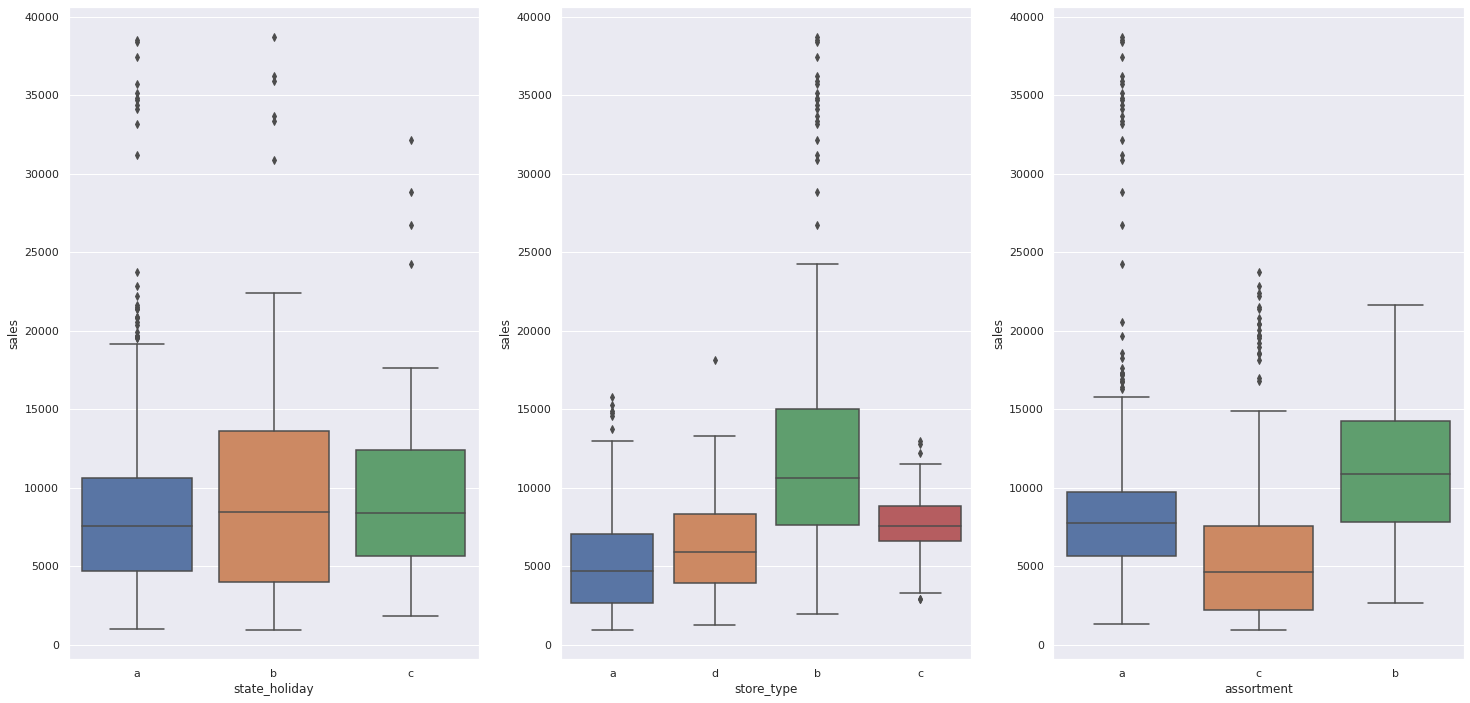

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)
plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)
plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0 PASSO 2 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

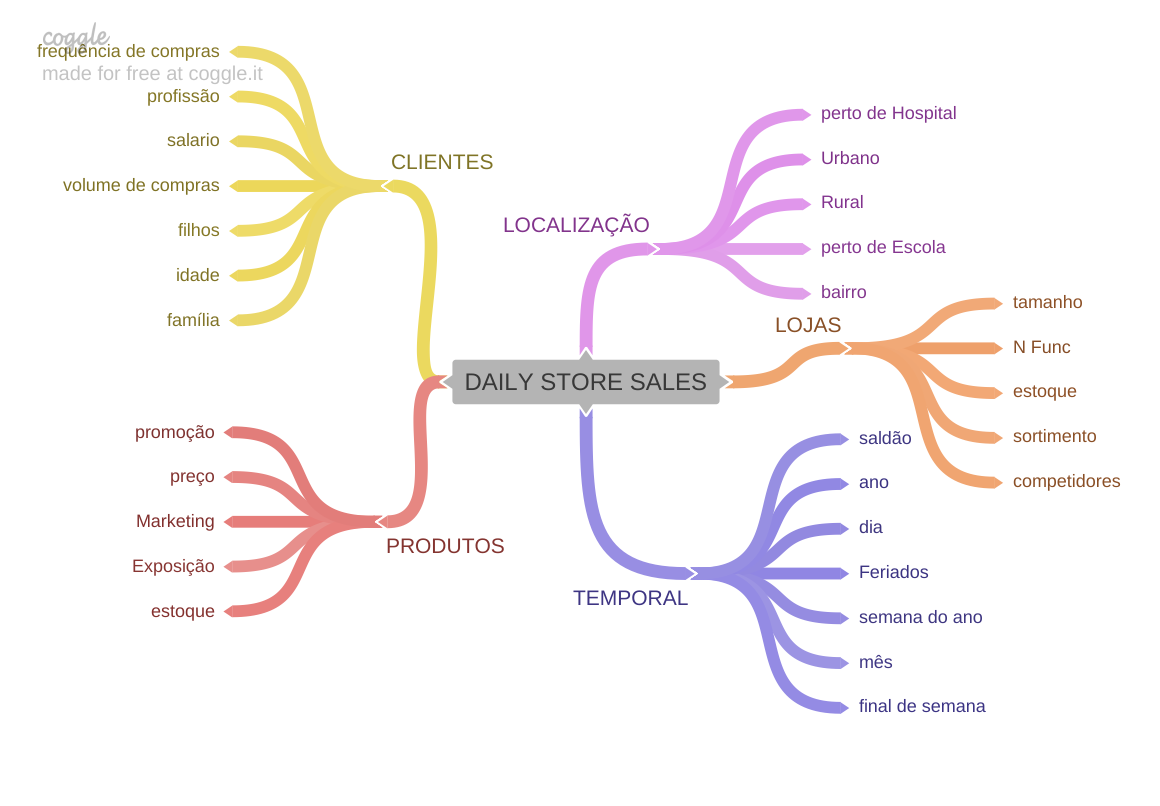

In [19]:
Image ('img/MindMapHypoteses.png')

## 2.2 Criação de Hipoteses

### 2.2.1 Hipoteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.
    
**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [20]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
  

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
##explicação gera uma data com o mes e ano das variaveis de promoção e data fixa em 1
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

##explicação date - competition since devolve um valor em dias . o lambda transforma em numero inteiro sem decimais. o astype muda pra tipo inteiro. o divide por 30 traz o valor em meses
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
##explicação junta as duas colunas em uma string para poder colocar no formado ANO-SEMANA
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state_holiday	
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )



In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEISdf3 = df2.copy()

In [22]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [25]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

/home/bernardo/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

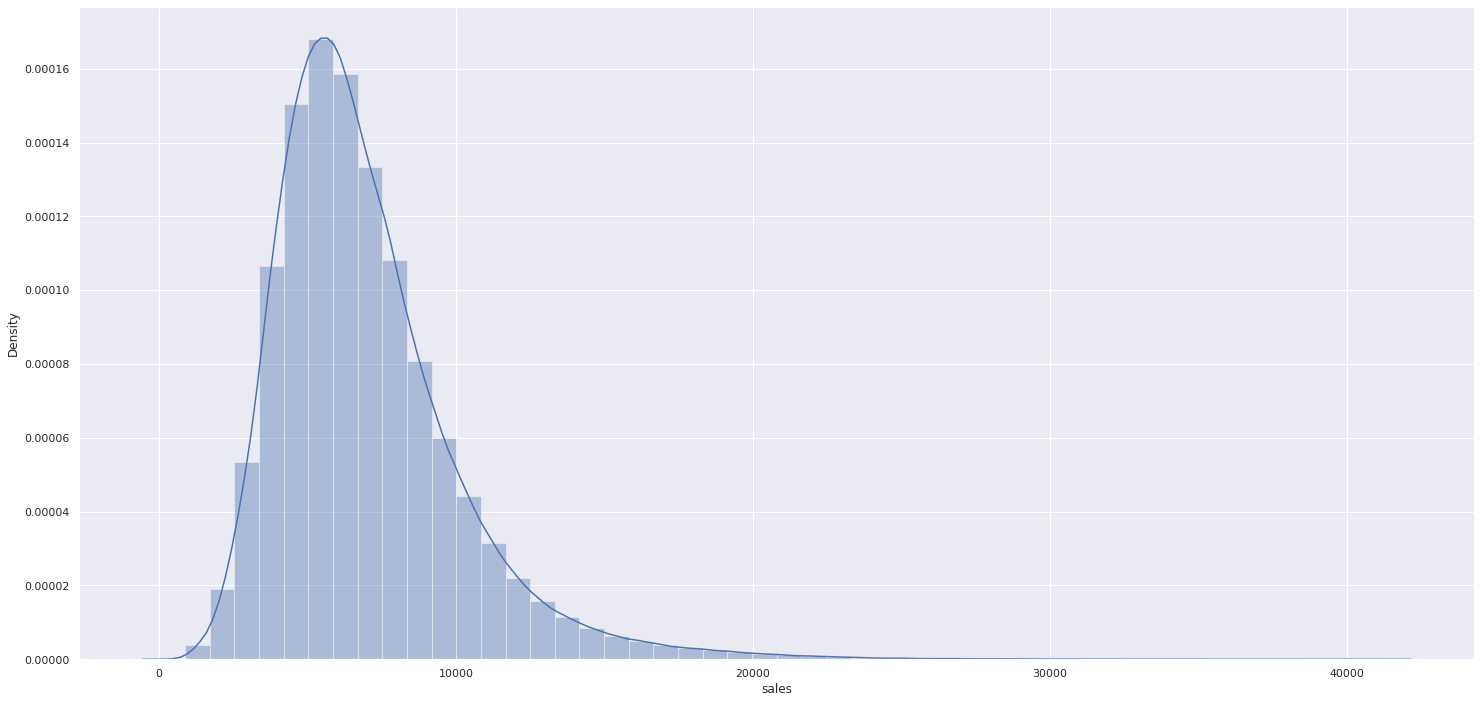

In [26]:
sns.distplot( df4['sales'])

<AxesSubplot:xlabel='sales', ylabel='Count'>

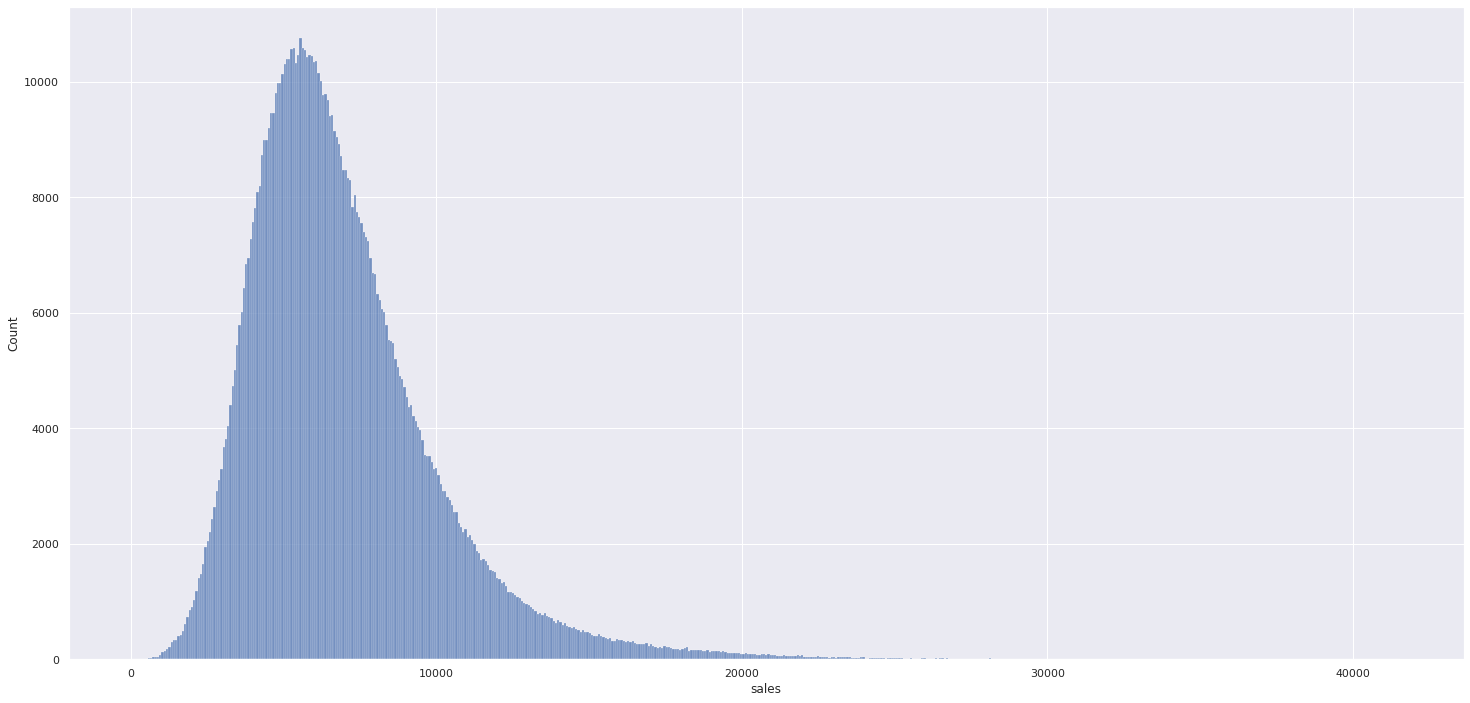

In [27]:
sns.histplot( df4['sales'])

### 4.1.2. Numerical Variable

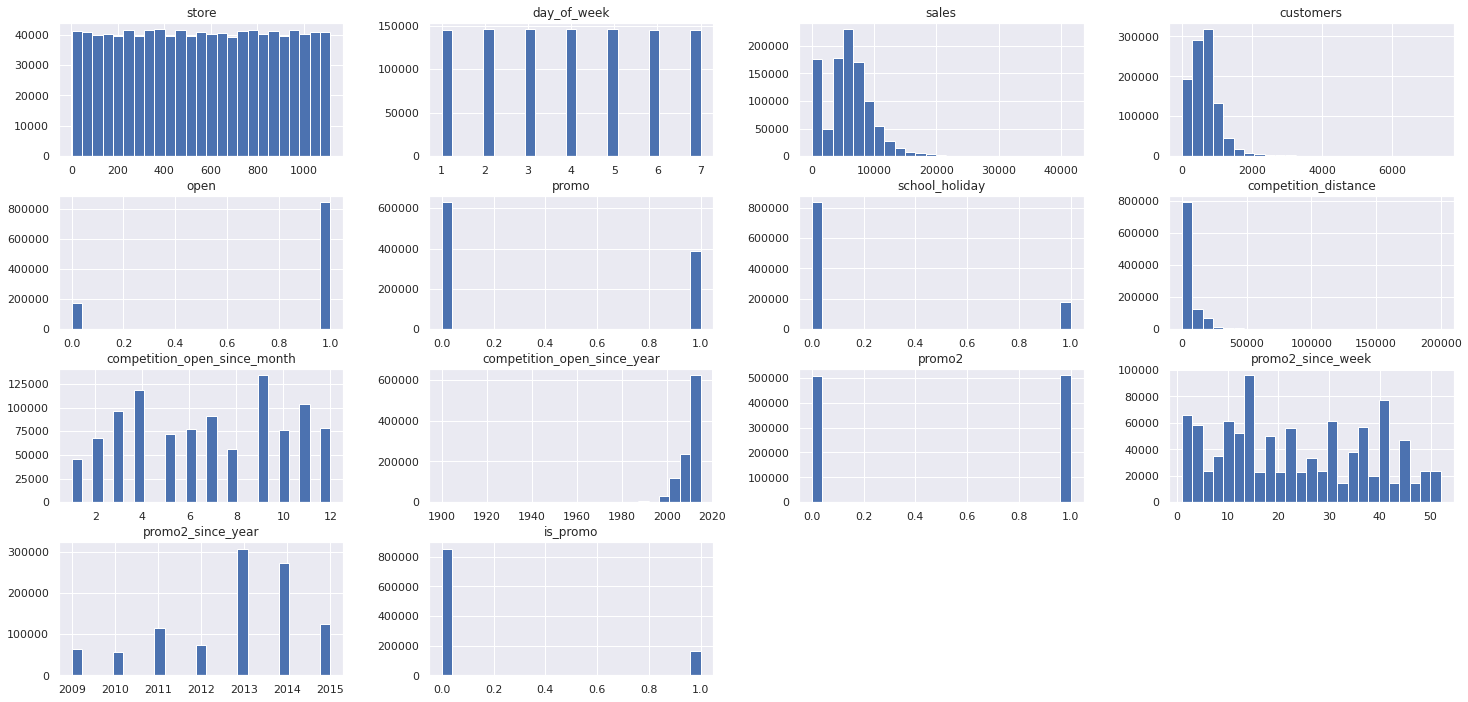

In [28]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variable

In [29]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


/home/bernardo/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/bernardo/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/bernardo/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and

<AxesSubplot:xlabel='sales', ylabel='Density'>

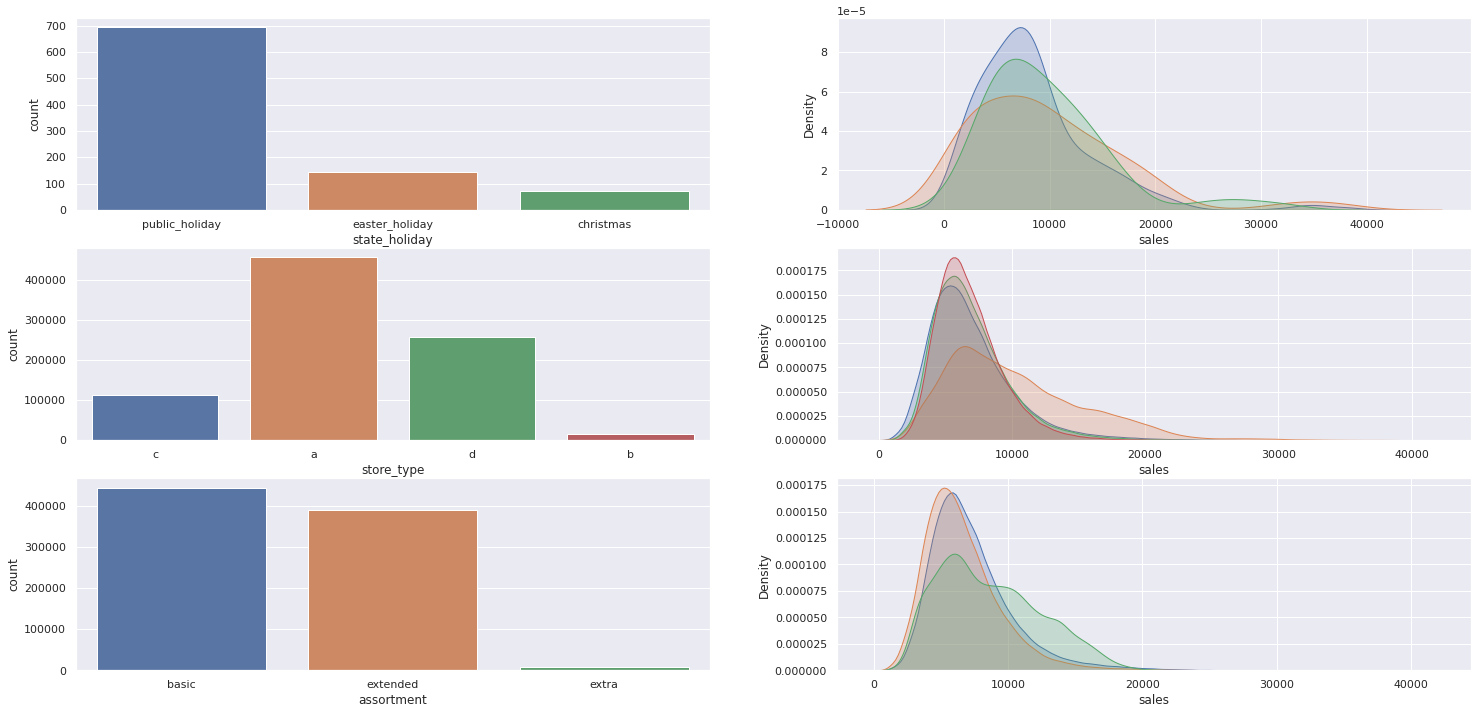

In [30]:
#state_holiday
df4['state_holiday'].drop_duplicates()
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holoday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type	

df4['store_type'].drop_duplicates()
plt.subplot( 3, 2, 3 )
sns.countplot(df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)


#assortment

df4['assortment'].drop_duplicates()
plt.subplot( 3, 2, 5 )
sns.countplot(df4['assortment'])

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'extended', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extended', shade = True)



## 4.2. Analise Bivariada

### **H1. Lojas com maior sortimentos deveriam vender mais.**
**FALSO** Lojas com MAIOR sortimento VENDEM MENOS


<AxesSubplot:xlabel='year_week'>

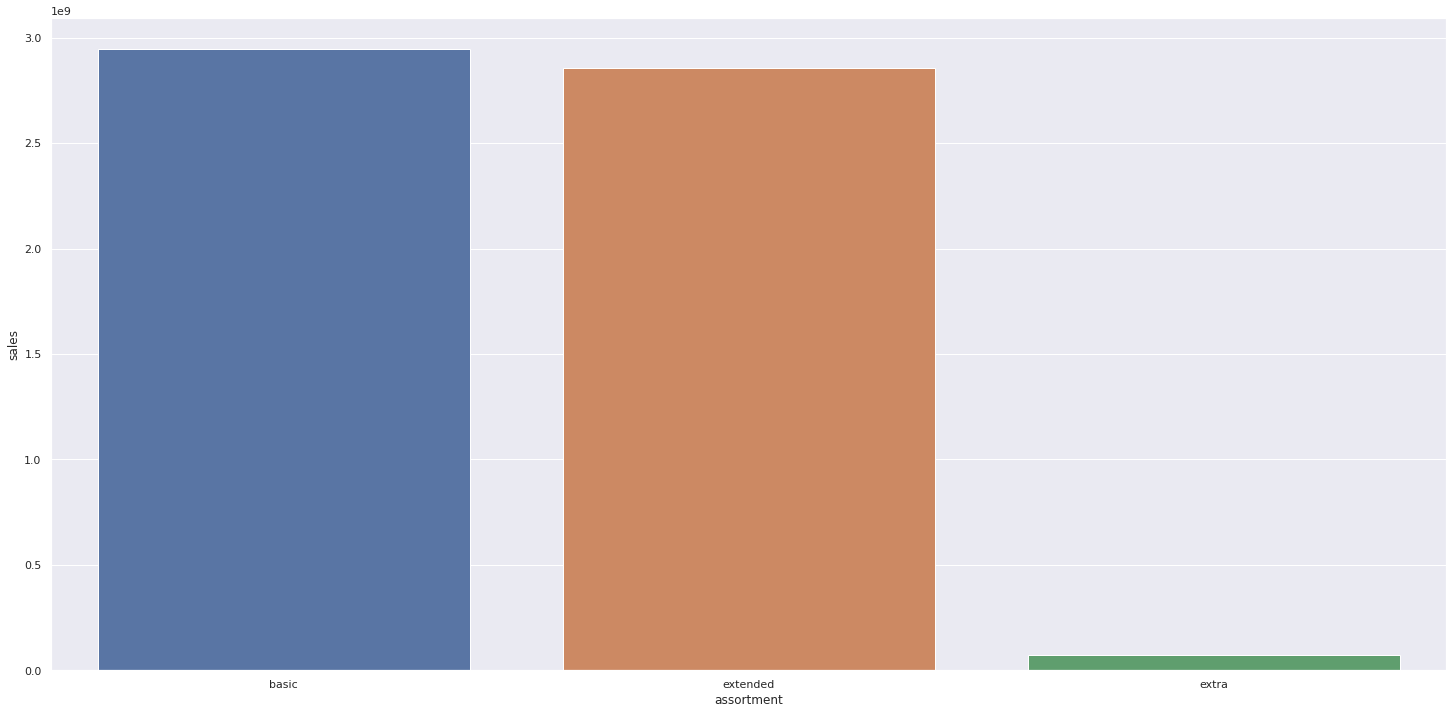

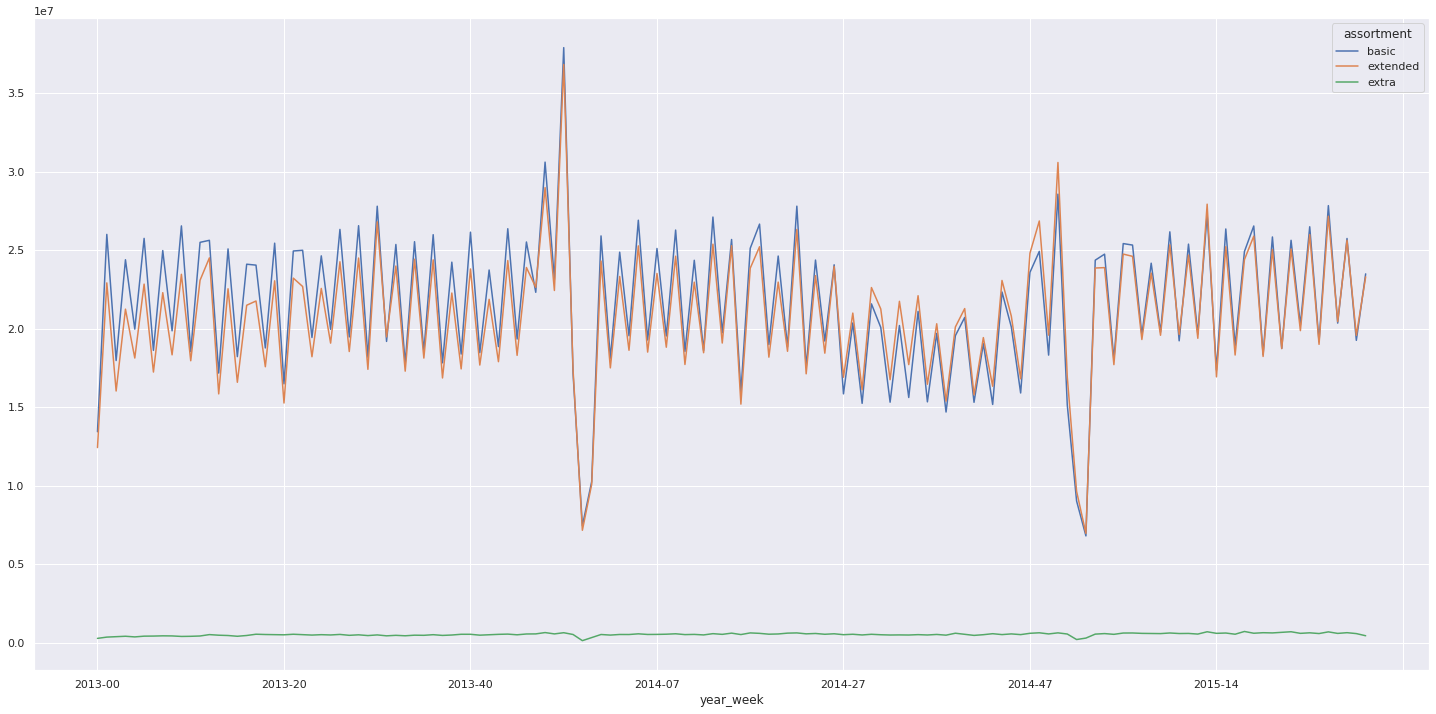

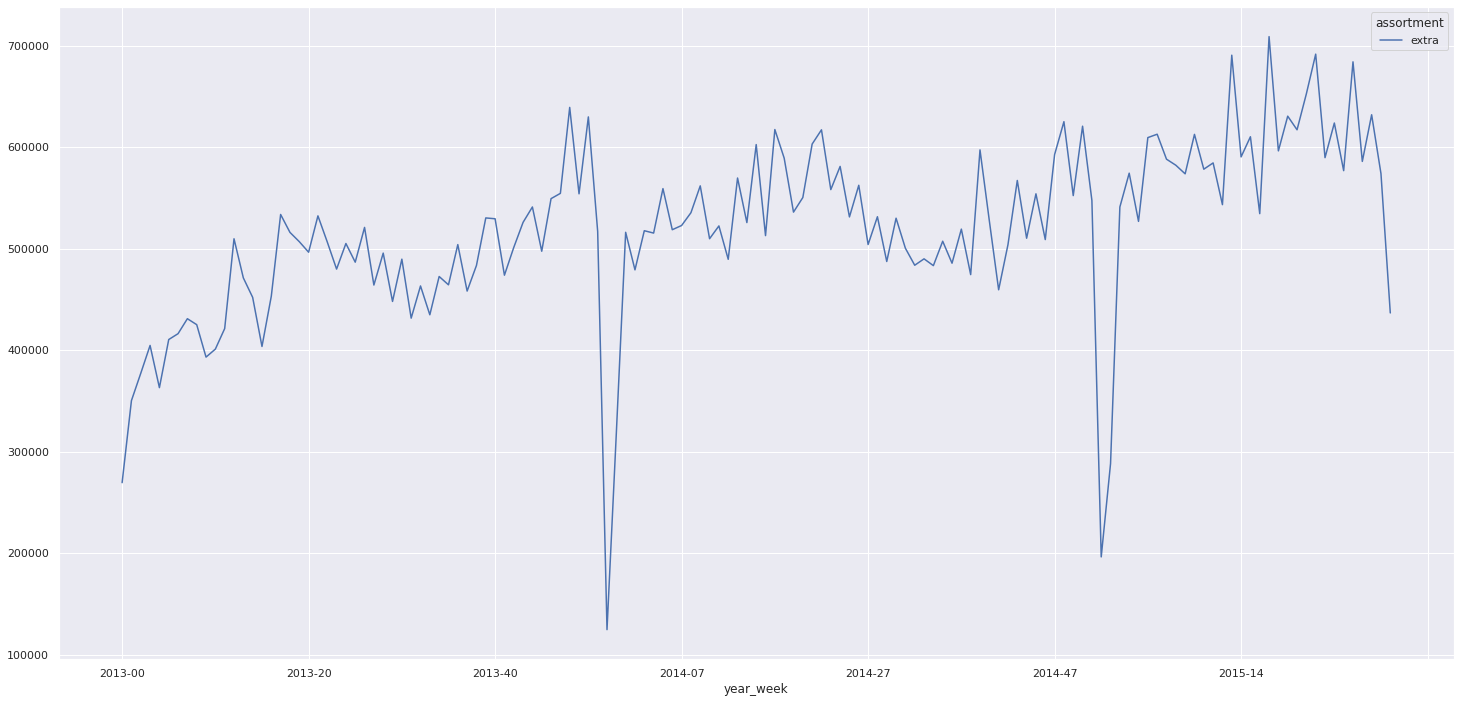

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y= 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra'] 
aux3.pivot(index = 'year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com competidores próximos vendem MAIS



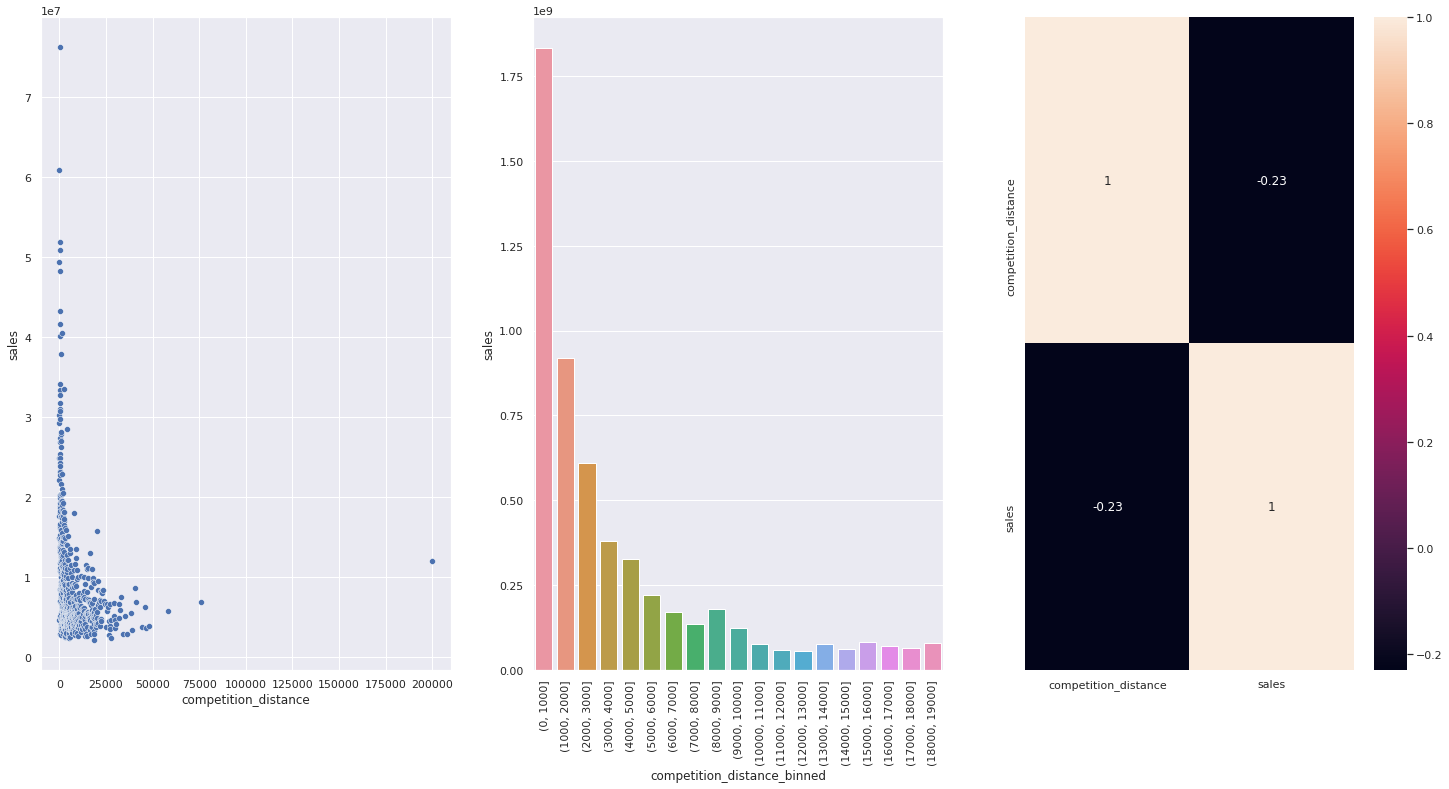

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] =  pd.cut(aux1['competition_distance'], bins = bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y= 'sales', data = aux2)
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True )


### **H3. Lojas com competidores à mais tempo deveriam vendem mais.**
**FALSO** Lojas com competidores a mais tempo vendem MENOS

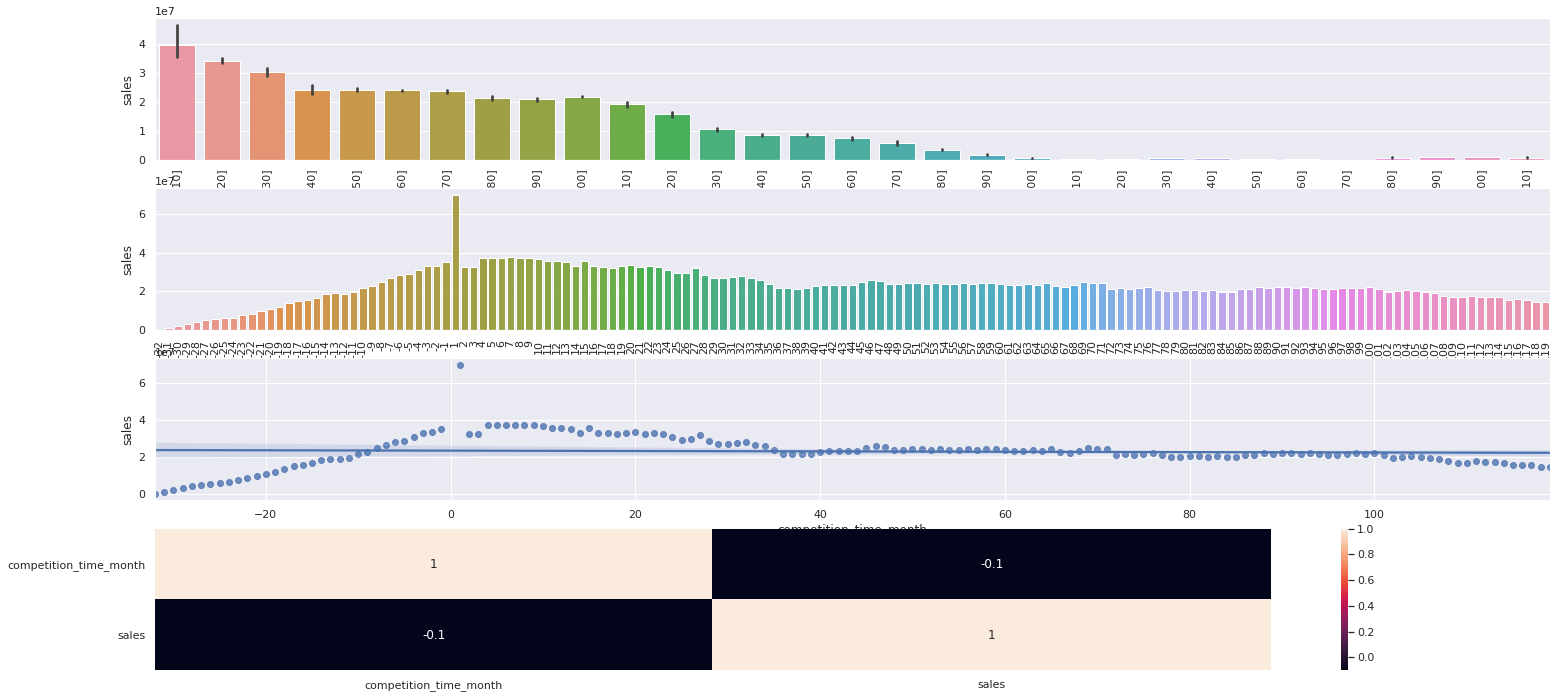

In [33]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot( 4, 1, 1 )
bins = list(np.arange(0, 320, 10))
aux1['competition_time_month_binned'] =  pd.cut(aux1['competition_time_month'], bins = bins)
sns.barplot(x = 'competition_time_month_binned', y= 'sales', data = aux1)
plt.xticks( rotation=90 );

plt.subplot( 4, 1, 2 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y= 'sales', data = aux2)
plt.xticks( rotation=90 );

plt.subplot( 4, 1, 3)
sns.regplot(x = 'competition_time_month', y= 'sales', data = aux2)

plt.subplot( 4, 1, 4)
sns.heatmap( aux1.corr( method='pearson'), annot=True );



### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

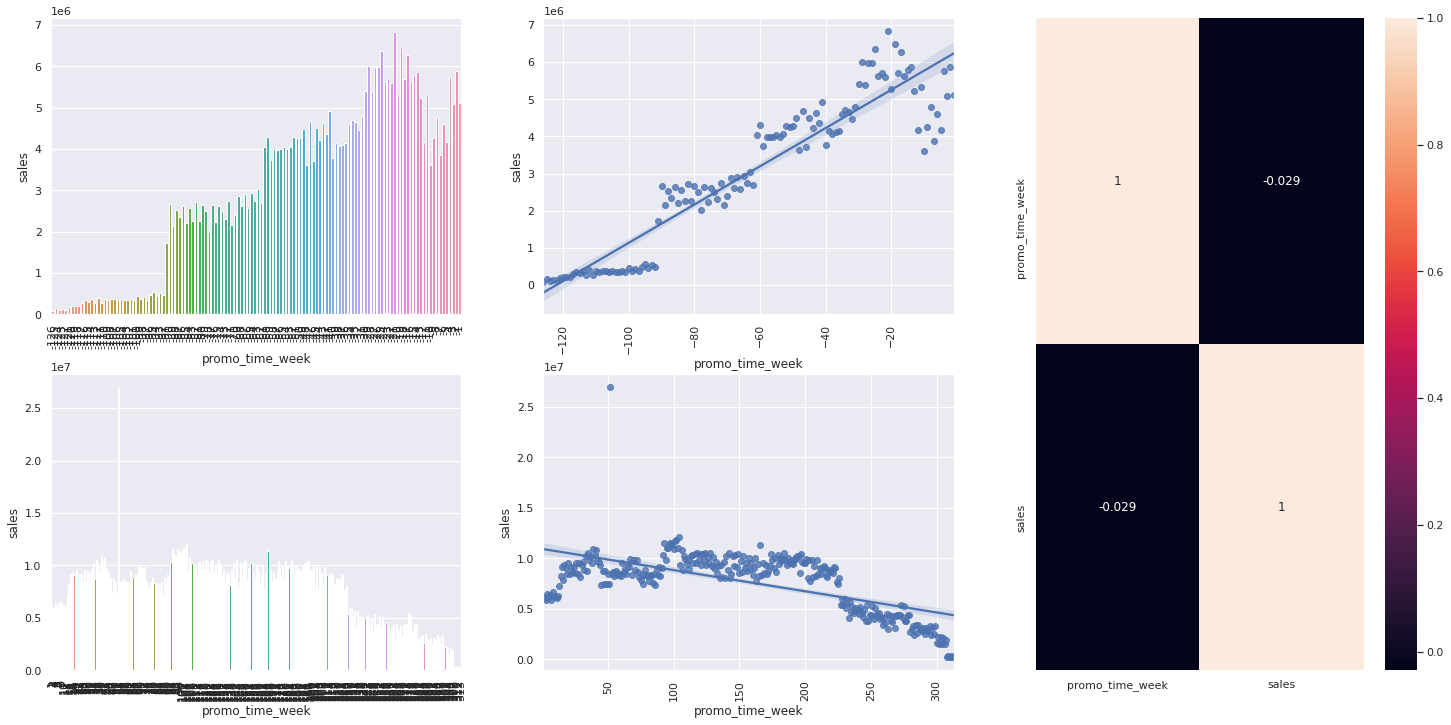

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux3 = aux1[aux1['promo_time_week'] <0] # periodo regular
sns.barplot(x = 'promo_time_week', y= 'sales', data = aux3)
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot(x = 'promo_time_week', y= 'sales', data = aux3)
plt.xticks( rotation=90 );


plt.subplot( grid[1,0] )
aux2 = aux1[aux1['promo_time_week'] >0] # periodo extendido
sns.barplot(x = 'promo_time_week', y= 'sales', data = aux2)
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot(x = 'promo_time_week', y= 'sales', data = aux2)
plt.xticks( rotation=90 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais. </s>



### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com promoções consecutivas vendem menos

In [35]:
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


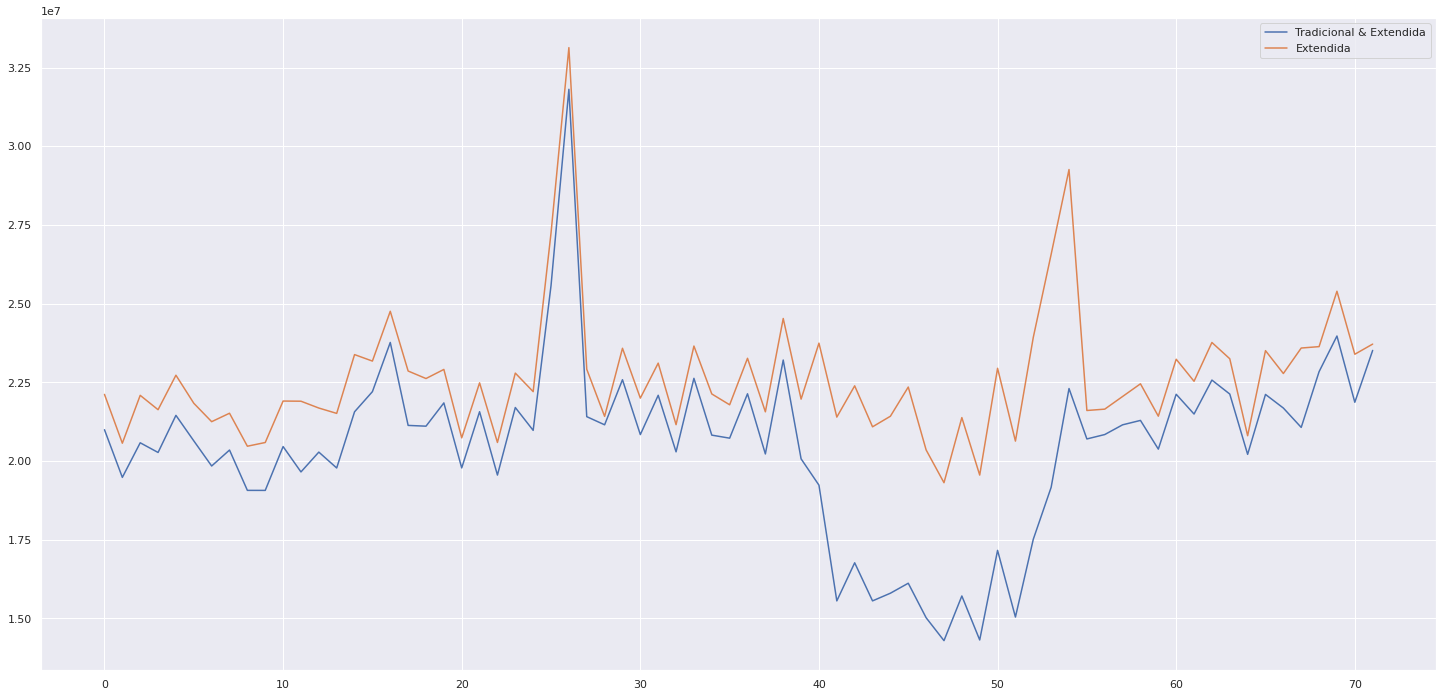

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1) ][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0) ][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas abertas no natal vendem menos


<AxesSubplot:xlabel='year', ylabel='sales'>

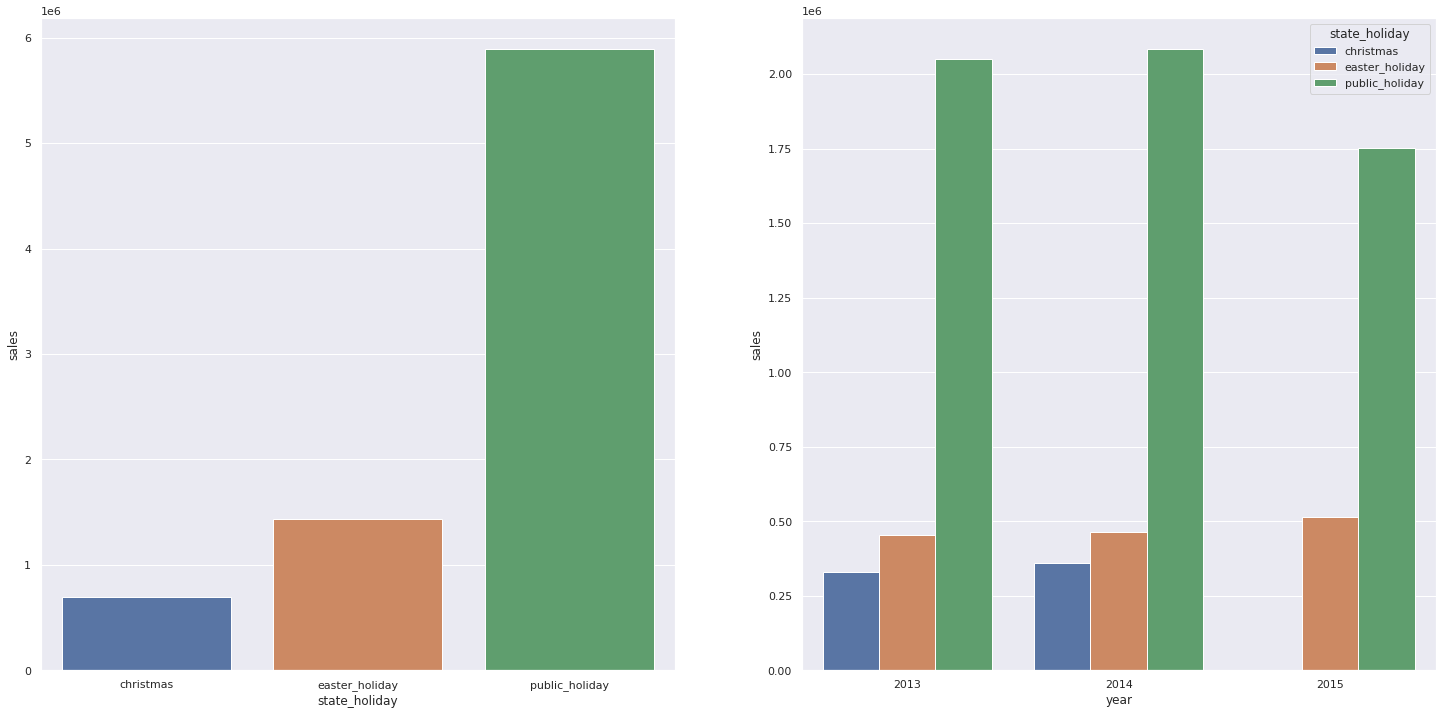

In [37]:
aux =df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y= 'sales', data=aux1)

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y= 'sales',hue='state_holiday', data=aux2)



### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** As lojas vendem menos ao longo dos anos

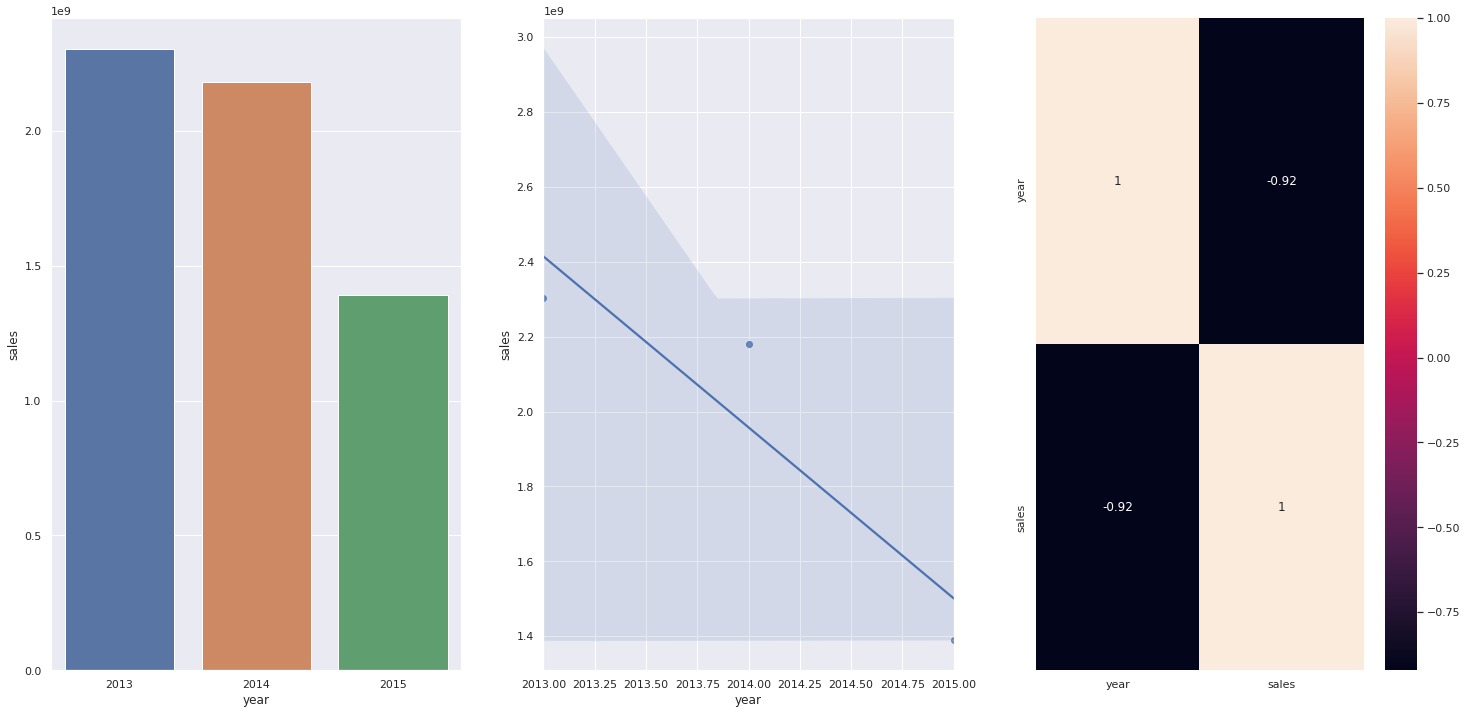

In [38]:
aux1= df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x= 'year', y='sales', data= aux1)

plt.subplot( 1, 3, 2 )
sns.regplot(x= 'year', y='sales', data= aux1)


plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre


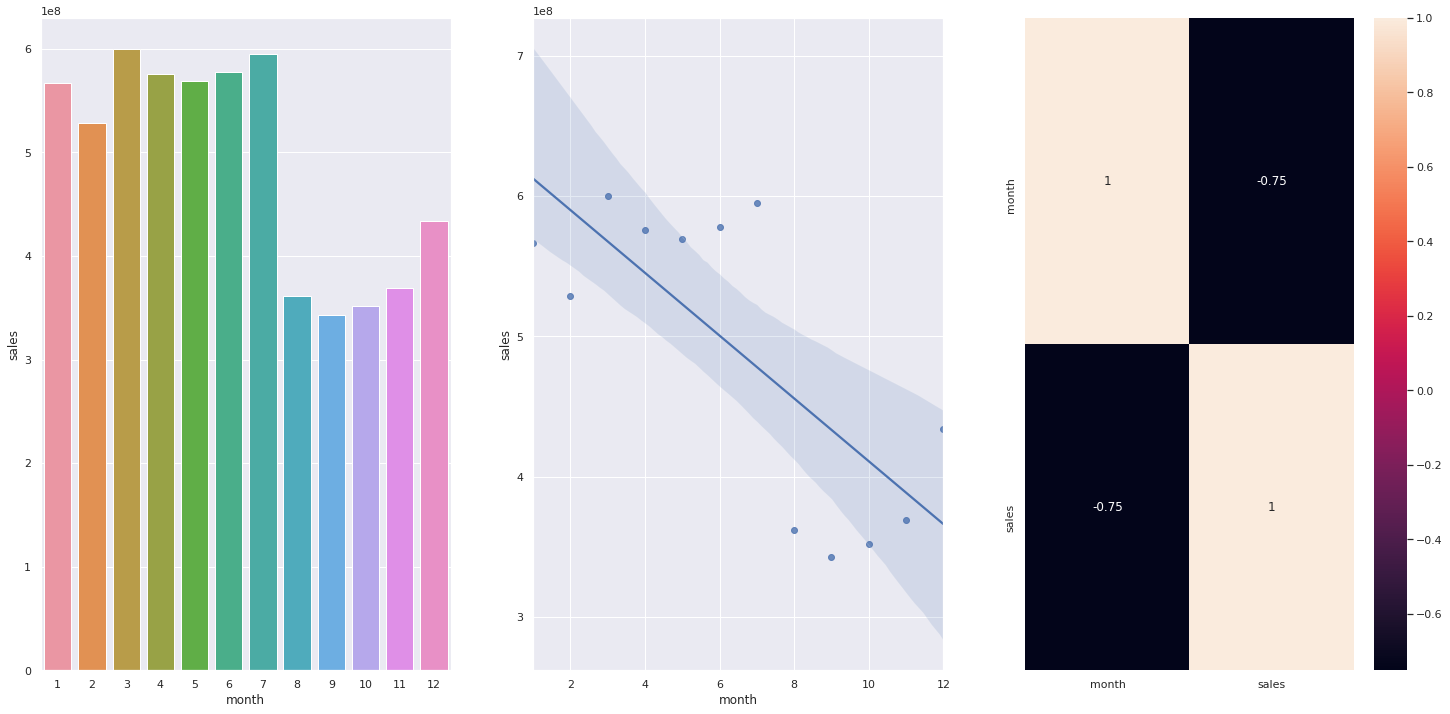

In [39]:
aux1= df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x= 'month', y='sales', data= aux1)

plt.subplot( 1, 3, 2 )
sns.regplot(x= 'month', y='sales', data= aux1)


plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** 

<AxesSubplot:xlabel='before_after', ylabel='sales'>

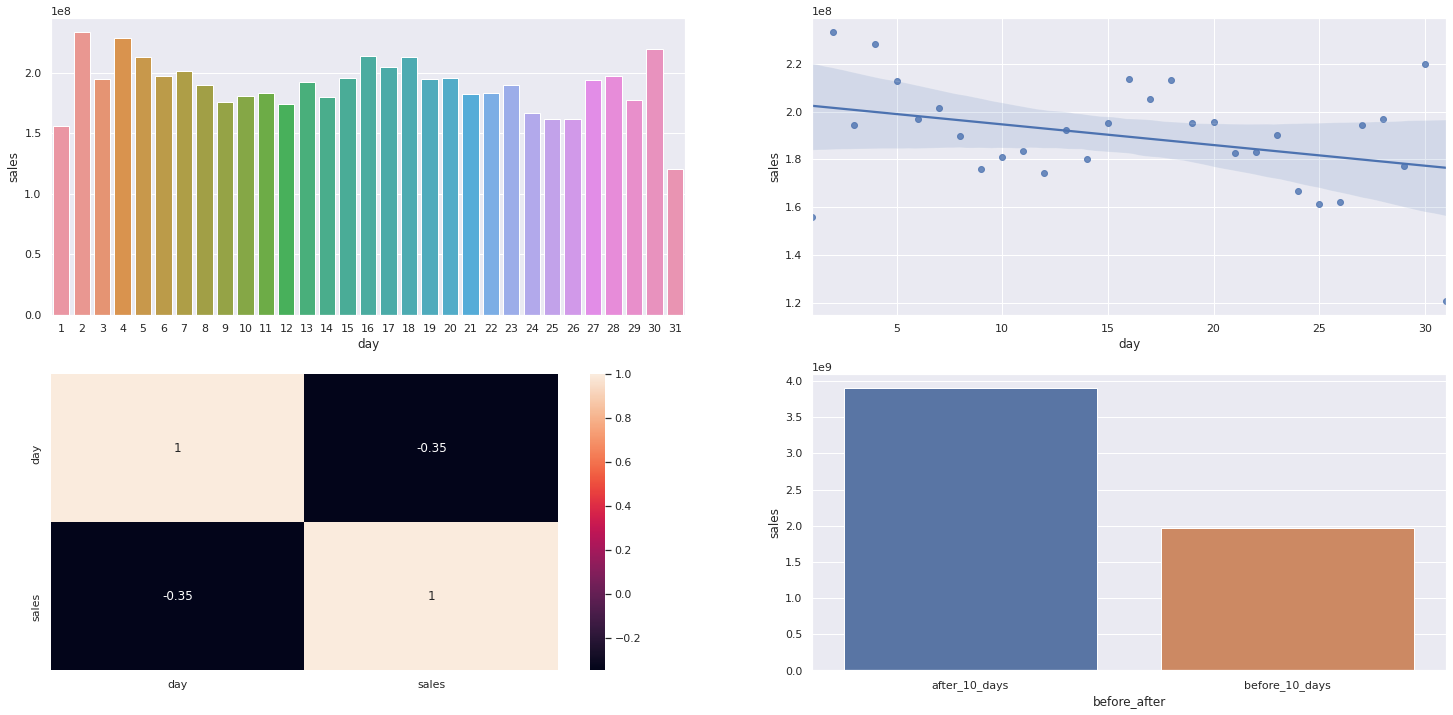

In [40]:
aux1= df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot(x= 'day', y='sales', data= aux1)

plt.subplot( 2, 2, 2 )
sns.regplot(x= 'day', y='sales', data= aux1)


plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x= 'before_after', y='sales', data= aux2)


### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO**

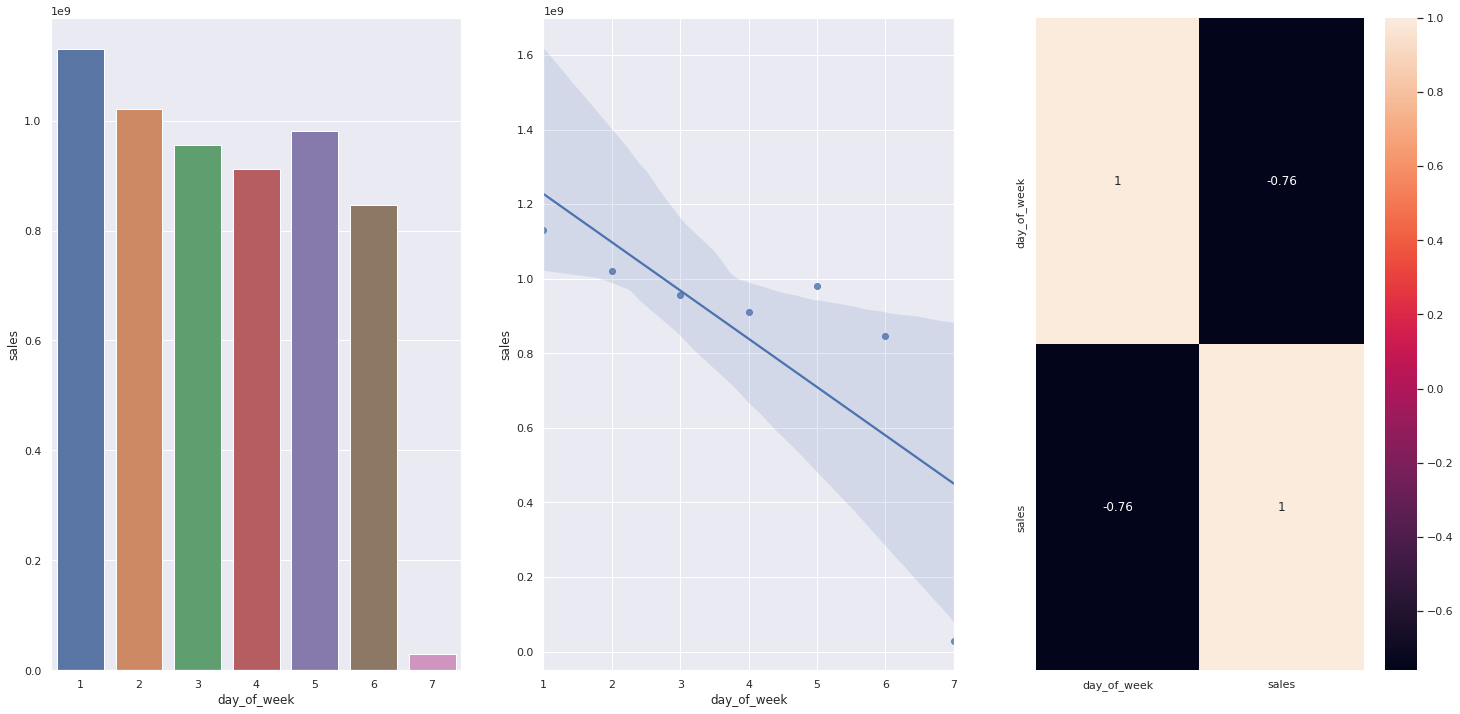

In [41]:
aux1= df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x= 'day_of_week', y='sales', data= aux1)

plt.subplot( 1, 3, 2 )
sns.regplot(x= 'day_of_week', y='sales', data= aux1)


plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** com exceção de Julho e Agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

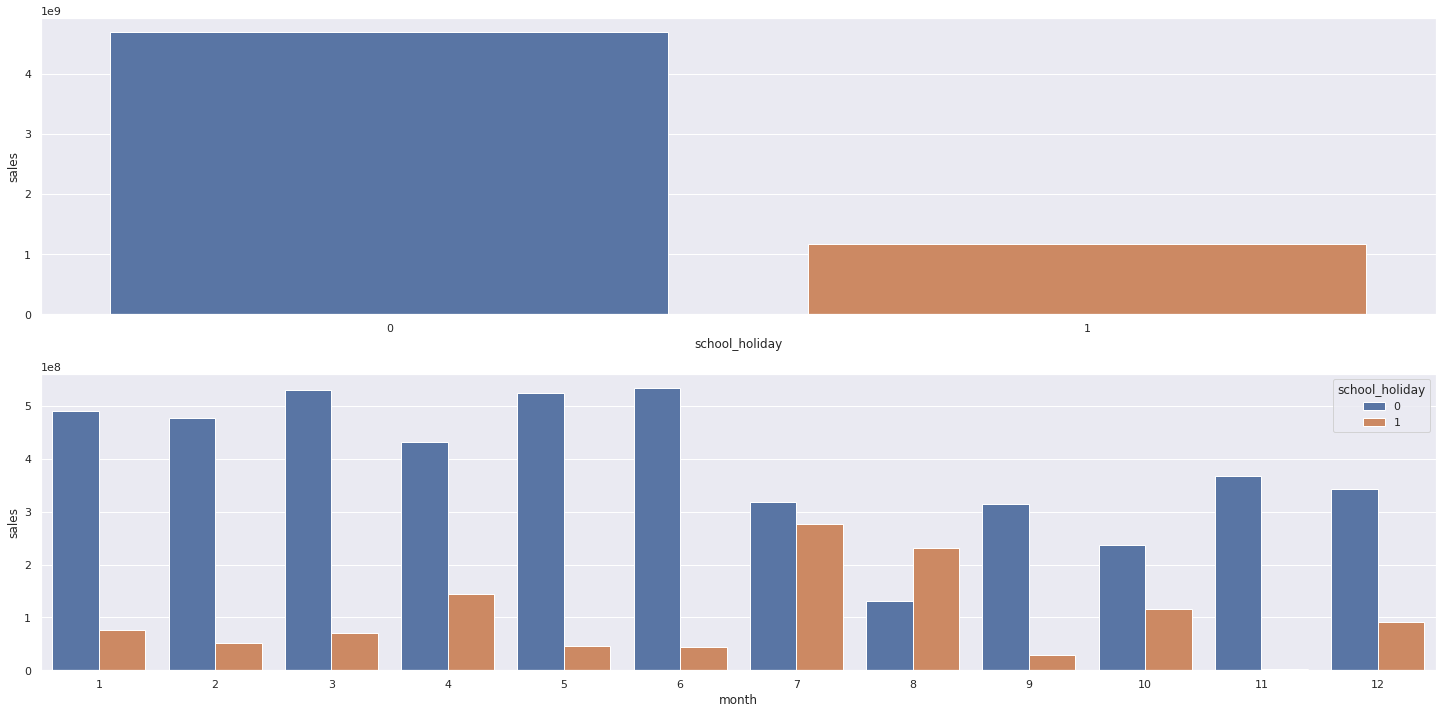

In [42]:
aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot(x= 'school_holiday', y='sales', data= aux1)


aux2= df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()


plt.subplot( 2, 1, 2 )
sns.barplot(x= 'month', y='sales', hue = 'school_holiday', data= aux2)

### 4.2.1. Resumo das Hipotesesfrom tabulate import tabulate

In [43]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Analise Multivariada

## 4.3.1 Numerical Attributes

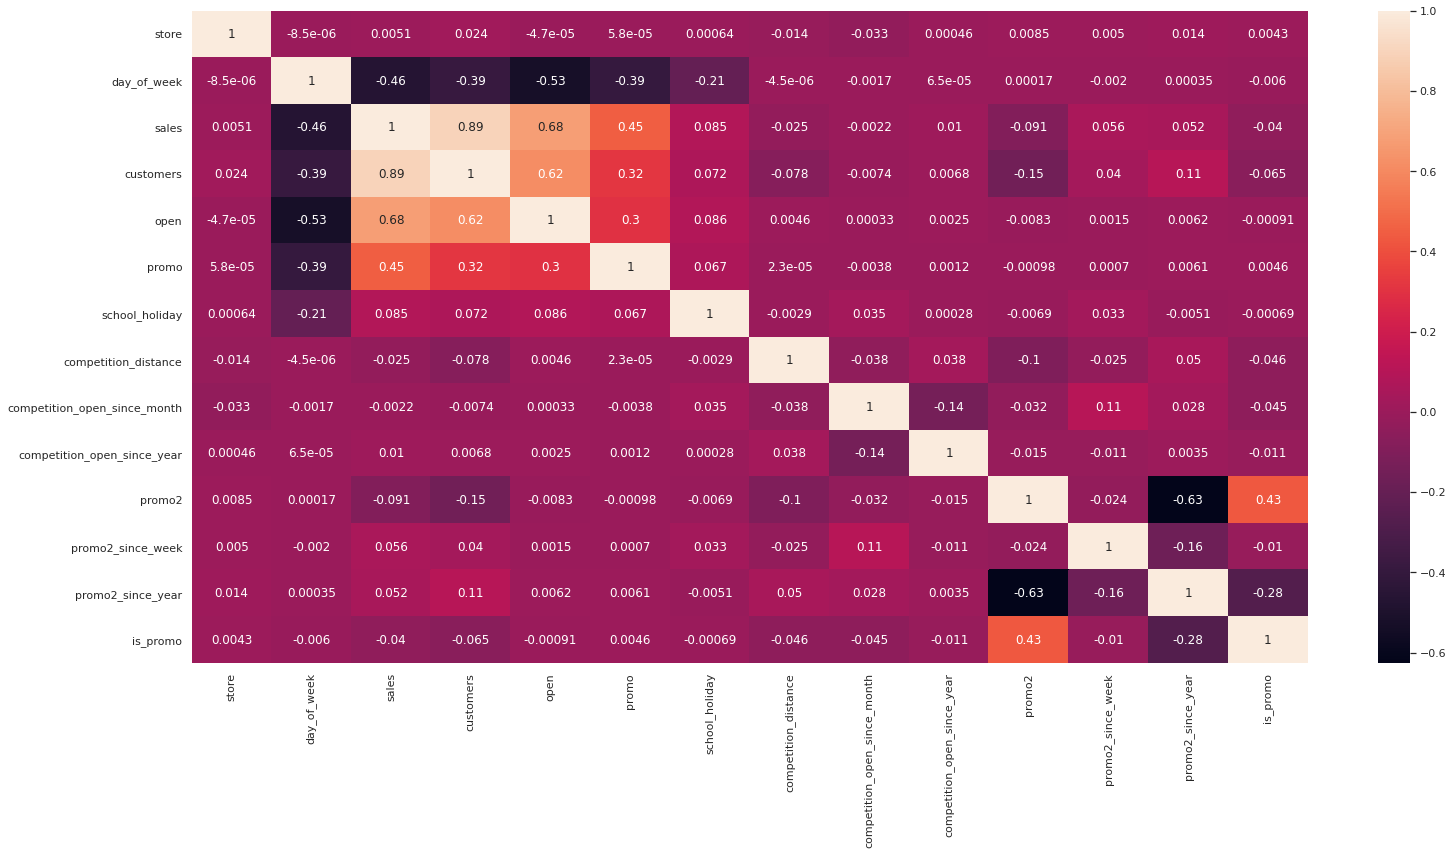

In [44]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

## 4.3.1 Categorical Attributes

<AxesSubplot:>

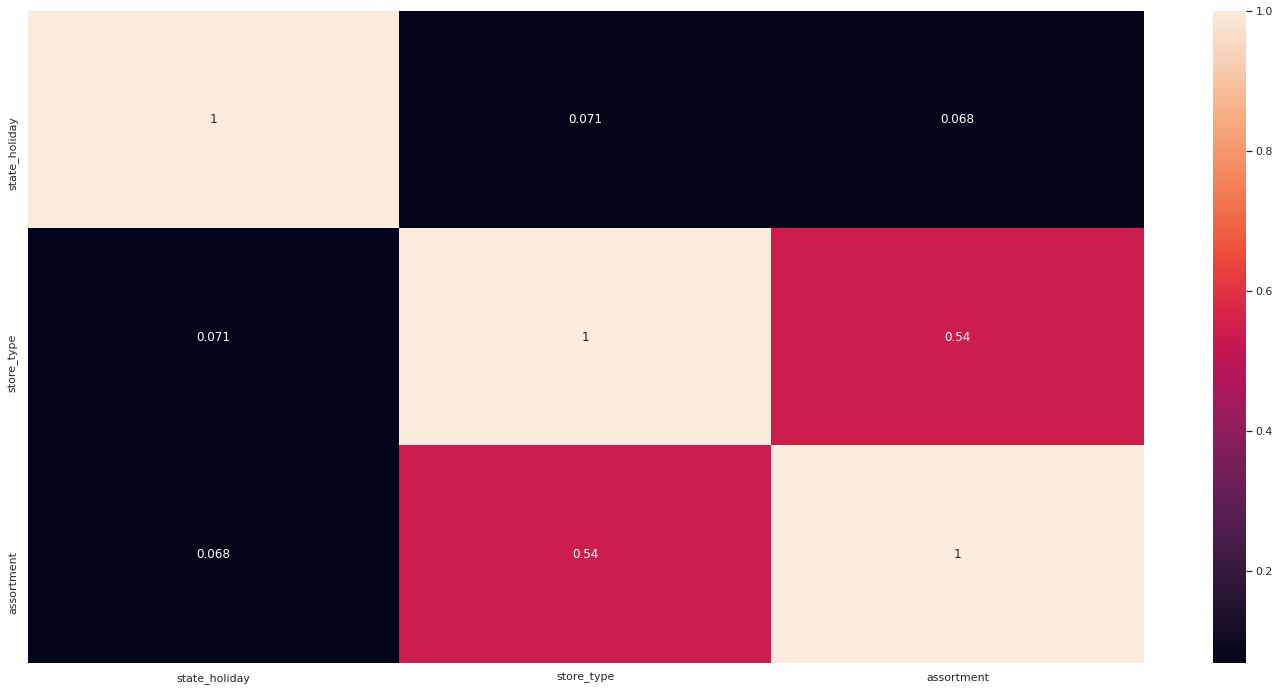

In [45]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 5 - DATA PREPARATION

In [46]:
df5 = df4.copy()

## 5.1. Normalização

Não existe nenhuma variável com curva normal

## 5.2. Rescaling

In [49]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [53]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


/home/bernardo/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

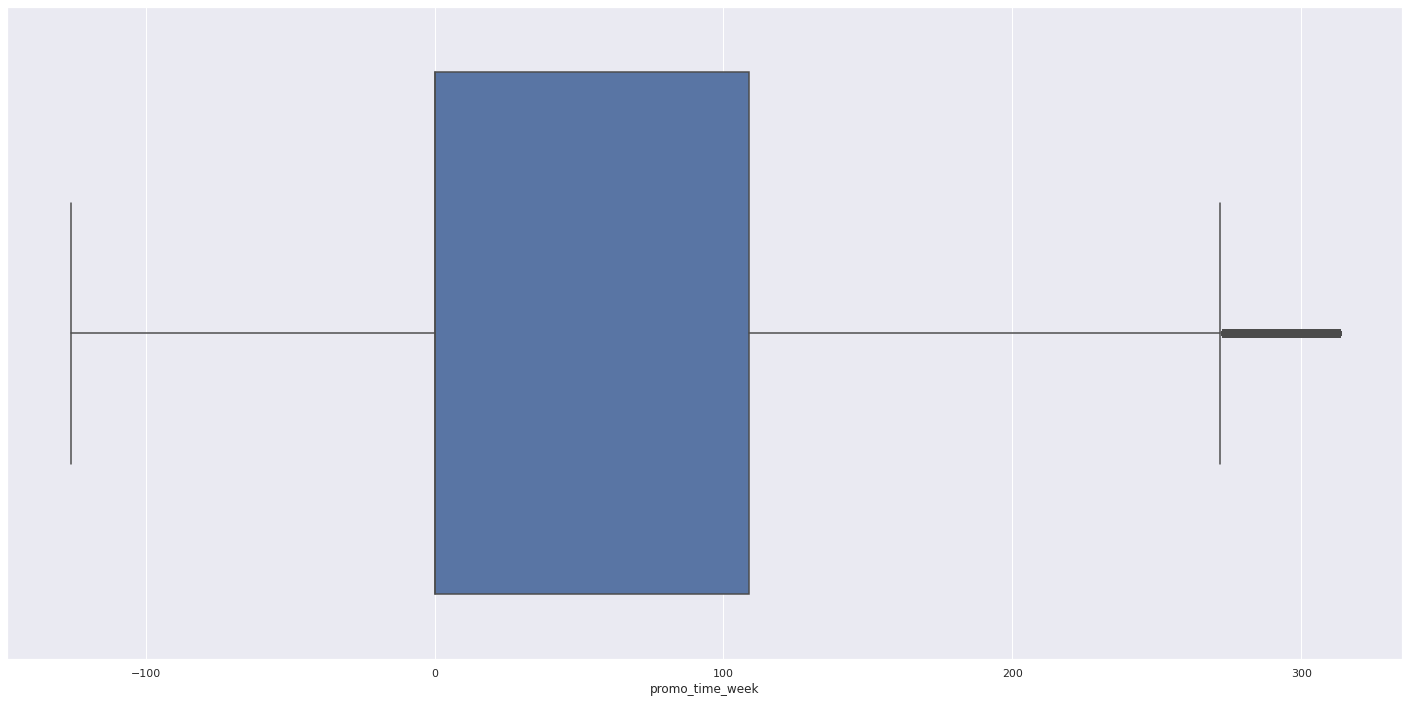

In [60]:
sns.boxplot(df5['promo_time_week'])

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
#year
df5['year'] = mms.fit_transform(df5[['year']].values)

/home/bernardo/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_time_month', ylabel='Density'>

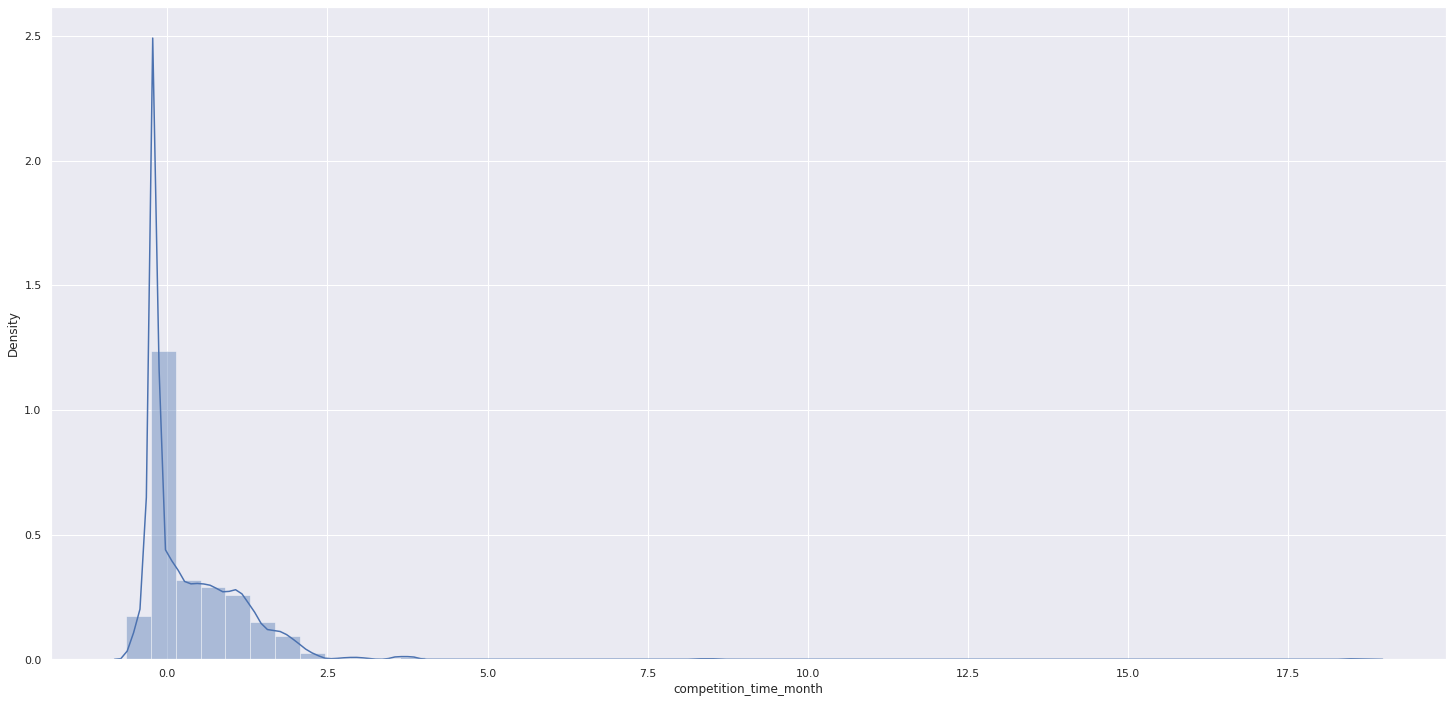

In [65]:
sns.distplot(df5['competition_time_month'])

## 5.3. Transformação

In [ ]:
#day of week
#week of year
#month
#day